In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np #verify the version for tensorflow
np.__version__

'1.21.0'

In [3]:
import tensorflow as tf #for machine learning and parametric UMAP
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.8.0
Num GPUs Available:  1
Num CPUs Available:  1


In [4]:
from scipy.special import expit as activation_function #for custom machine learning method
from scipy.stats import truncnorm

In [5]:
import scvelo as scv #for velocity embedding 

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import random
%matplotlib inline
from umap.parametric_umap import ParametricUMAP

# <b>velocity embedding method using UMAP<b>

process :

- use UMAP parametrization to "learn" a function that go from 3D to 2D (on cells data)
- use this function to translate the velocity vector fied in 2D
- reverse the parametrisation in order to compare

test : 

- generate random cells in 3D and a random velocity vector field on it.
- go from 3D to 2D using the embedding method
- use the reverse function to go from 2D to 3D again
- compare reconstruction with original data 

# UMAP mapping

In [7]:
# UMAP embedding of cells (normal umap)

def umap_mapping(C):
    fit = umap.UMAP() #use the normal embedding process
    embedding = fit.fit_transform(C) #fit random
    #embedding = fit.fit_transform(data_p)

    #plot
    plt.figure(figsize=(12, 12))
    plt.title("UMAP cells embedding")
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(embedding[:, 0],
    embedding[:, 1])

    plt.show()
    
    return embedding

# parametric UMAP mapping

In [8]:
# use parametric umap

def PUMAP_mapping(C):
    embedder = ParametricUMAP()
    embedding_param = embedder.fit_transform(C) # random
    #plot
    plt.figure(figsize=(12, 12))
    plt.title("UMAP cells embedding")
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(embedding_param[:, 0],
    embedding_param[:, 1])

    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(embedder._history['loss'])
    ax.set_ylabel('Cross Entropy')
    ax.set_xlabel('Epoch')
    
    return embedder,embedding_param

In [9]:
# or custom network !

# Generate random numbers within a truncated (bounded) 
# normal distribution:
def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Create the ‘Nnetwork’ class and define its arguments:
# Set the number of neurons/nodes for each layer
# and initialize the weight matrices:  
class Nnetwork:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, 
                                        self.no_of_hidden_nodes))

    def train(self, input_vector, target_vector):
        pass # More work is needed to train the network
            
    def run(self, input_vector):
        """
        running the network with an input vector 'input_vector'. 
        'input_vector' can be tuple, list or ndarray
        """
        # Turn the input vector into a column vector:
        input_vector = np.array(input_vector, ndmin=2).T
        # activation_function() implements the expit function,
        # which is an implementation of the sigmoid function:
        input_hidden = activation_function(self.weights_in_hidden @   input_vector)
        output_vector = activation_function(self.weights_hidden_out @ input_hidden)
        return output_vector 

# use neural network to learn the UMAP model 

# Initialize an instance of the class:  
parametric_network = Nnetwork(no_of_in_nodes=2, 
                               no_of_out_nodes=2, 
                               no_of_hidden_nodes=4,
                               learning_rate=0.6)


# Embedding of the vector field with the UMAP mapping

In [49]:
def velocity_calculus(embedder,embedding, V,C) :
    velocity = embedder.transform(V + C) - embedding
    Vector_plot(embedding,velocity)
    return velocity

In [48]:
def Vector_plot(embedding,velocity) :
   
    #plot
    plt.figure(figsize=(12, 12))
    plt.title("UMAP cells embedding")
    plt.xlabel('X')
    plt.ylabel('Y')
    

    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.quiver(embedding[:, 0],embedding[:, 1],velocity[:, 0],velocity[:, 1])


    plt.show()

# inverse transform of the embedding

In [11]:
def inversion(embedder, embedding) :
    embedding_inverse = embedder.inverse_transform(embedding)

    #plot
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(embedding_inverse[:, 0],embedding_inverse[:, 1],embedding_inverse[:, 2])

    ax.set_title('simulation of cells')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    
    return embedding_inverse

In [12]:
def dist(C,I) :
    if(C.shape[0] != 0) :
        return np.sum(np.sqrt(np.sum(np.square(C-I))))/C.shape[0]
    else :
        return "error : null dimension"

# velocity mapping using the gradiant

In [13]:
# compute the gradiant
def velocity_embedding(C,embedder,V) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    x = C # point in high dimension
    x = list(x)
    x = tf.constant(x)
    with tf.GradientTape() as t:
        t.watch(x)
        y = embedder.encoder(x)[:,0] #function learned by parametric UMAP
    
    dy_dx = t.gradient(y, x) # determine the gradiant
    
    with tf.GradientTape() as t:
        t.watch(x)
        z = embedder.encoder(x)[:,1]

    dz_dx = t.gradient(z, x)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    embedded_velocity = np.random.rand(V.shape[0], 2)
    for i in range(V.shape[0]) :
        v = [np.sum(dy_dx.numpy()[i,:]*V[i,:]),np.sum(dz_dx.numpy()[i,:]*V[i,:])]
        embedded_velocity[i] = v
        
    return embedded_velocity

# <b>Application on artifial (or random) data<b>

# data generation

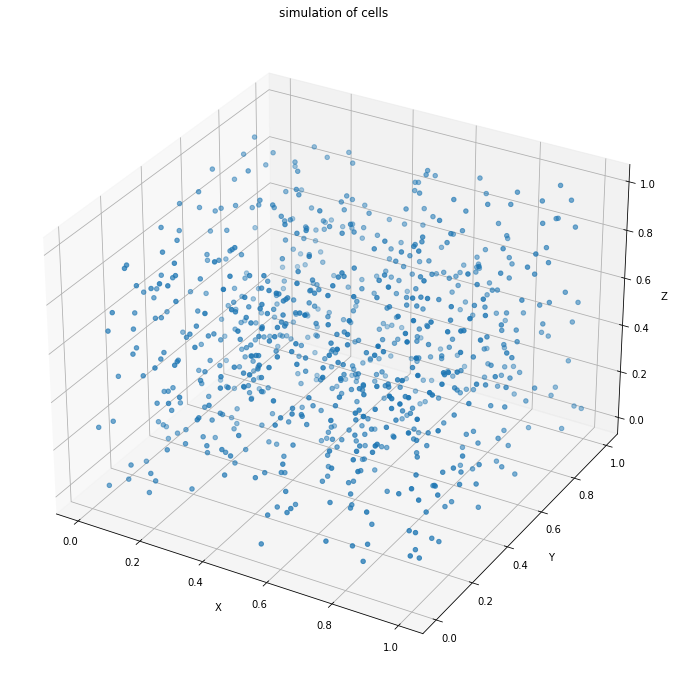

In [14]:
# generation of data (cells)

n = 800 

#np.random.seed(42) #fix the seed
cells = np.random.rand(n, 3) #random cells data
# how to make it look more biological ? use real word data or clustered data ?
#plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(cells[:, 0],cells[:, 1],cells[:, 2])

ax.set_title('simulation of cells')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

[[0.09724136 0.01695203 0.01602332]
 [0.09937467 0.0110977  0.00123098]
 [0.09818655 0.0160268  0.01012639]
 ...
 [0.09863557 0.0037844  0.01602197]
 [0.09754121 0.01324005 0.01761857]
 [0.08932175 0.03466612 0.02863364]]


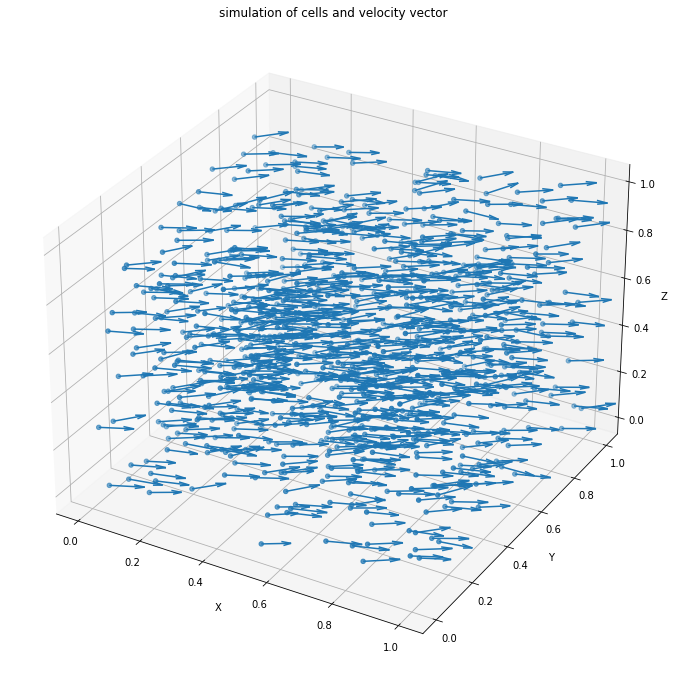

In [15]:
# generation of data (vector field)

k = 10 #normalisation constant for the velocity field


velocity = np.random.rand(800, 3) #generate velocity random

theta = [random.uniform(0, 2*np.pi) for i in range(0, n)]
phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]

velocity[:, 0] = np.sin(theta)*np.cos(phi)
velocity[:, 1] = np.sin(theta)*np.sin(phi)
velocity[:, 2] = np.cos(theta)

for i in range(velocity.shape[0]) :
    velocity[i, 0] = 10 + random.uniform(0, 2*np.pi) #generate velocity in a particular direction
    velocity[i, 1] = random.uniform(0, 2*np.pi)
    velocity[i, 2] = random.uniform(0, 2*np.pi)

norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2+ velocity[:, 2]**2)*k #normalisation
velocity[:, 0] = velocity[:, 0]/norm
velocity[:, 1] = velocity[:, 1]/norm
velocity[:, 2] = velocity[:, 2]/norm

print(velocity)
#plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(cells[:, 0],cells[:, 1],cells[:, 2])

ax.quiver(cells[:, 0],cells[:, 1],cells[:, 2],velocity[:, 0],velocity[:, 1],velocity[:, 2])

ax.set_title('simulation of cells and velocity vector')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

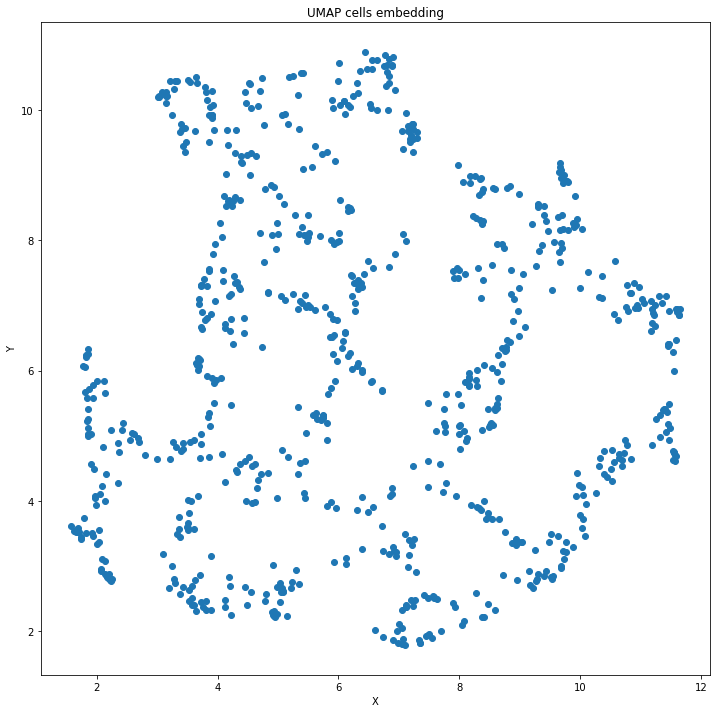

In [16]:
embedding = umap_mapping(cells)

Metal device set to: Apple M1 Pro
Epoch 1/10


2022-05-04 10:17:43.469324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-04 10:17:43.469444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-04 10:17:43.648343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-04 10:17:44.200134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


295/295 [==============================] - 8s 25ms/step - loss: 0.3927
Epoch 2/10
295/295 [==============================] - 7s 24ms/step - loss: 0.2046
Epoch 3/10
295/295 [==============================] - 7s 24ms/step - loss: 0.2014
Epoch 4/10
295/295 [==============================] - 7s 25ms/step - loss: 0.1996
Epoch 5/10
295/295 [==============================] - 7s 24ms/step - loss: 0.1979
Epoch 6/10
295/295 [==============================] - 7s 25ms/step - loss: 0.1959
Epoch 7/10
295/295 [==============================] - 7s 25ms/step - loss: 0.1932
Epoch 8/10
295/295 [==============================] - 7s 24ms/step - loss: 0.1927
Epoch 9/10
295/295 [==============================] - 7s 24ms/step - loss: 0.1901
Epoch 10/10
295/295 [==============================] - 7s 24ms/step - loss: 0.1896


2022-05-04 10:18:56.863254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


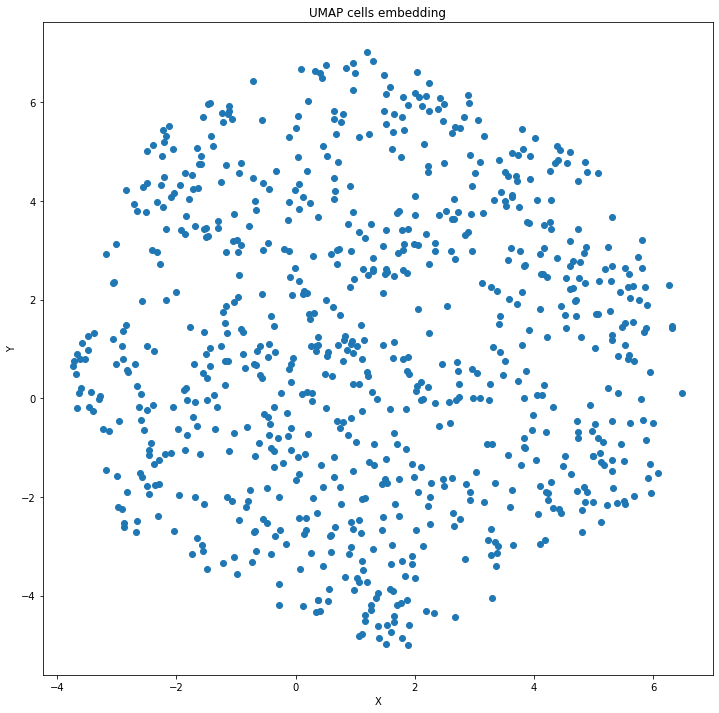

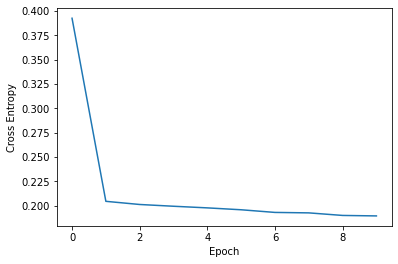

In [17]:
embedder, embedding_param = PUMAP_mapping(cells)

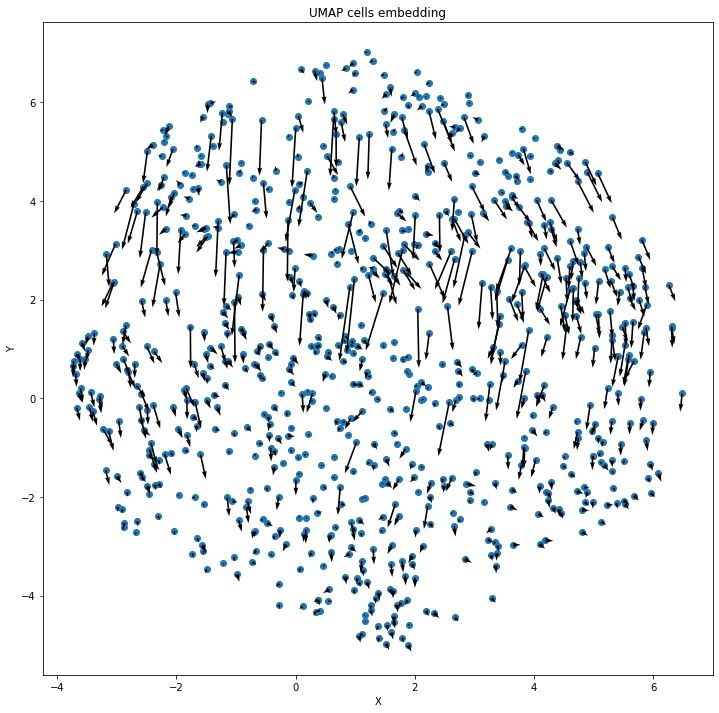

In [51]:
velo = velocity_calculus(embedder,embedding_param,velocity,cells)

In [43]:
#Vector_plot(embedder,embedding, velocity,cells)

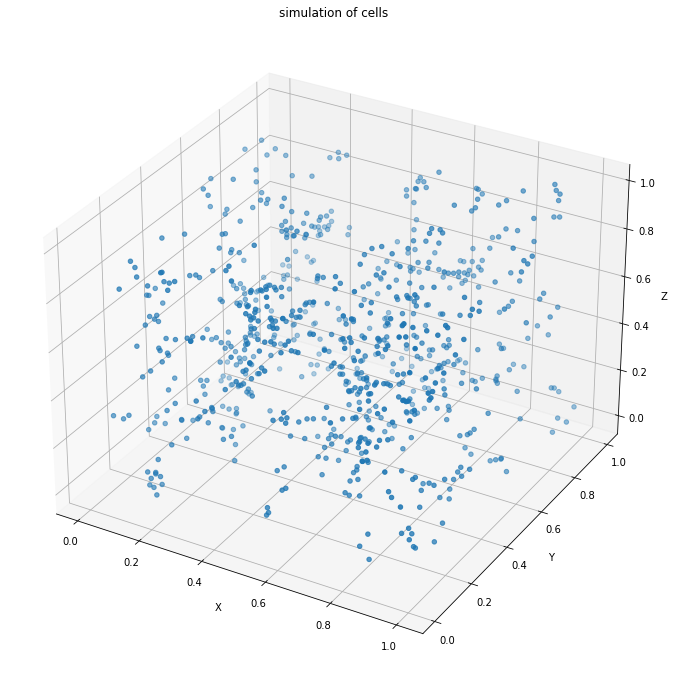

In [20]:
embedding_inverse = inversion(embedder,embedding_param)

In [21]:
dist(cells, embedding_inverse)

0.0060014097593161534

In [44]:
#embedding_inverse2 = inversion(embedder,embedding)

In [23]:
dist(cells, embedding_inverse2)

0.025581358468722008

In [52]:
embedded_velocity = velocity_embedding(cells,embedder,velocity)

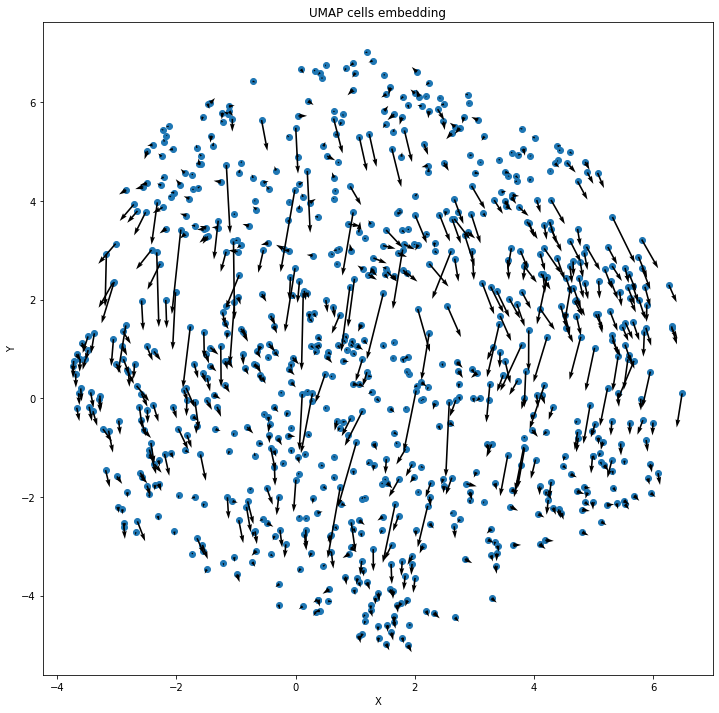

In [53]:
Vector_plot(embedding_param, embedded_velocity)

In [54]:
dist(velo,embedded_velocity)

0.015320661997300335

# <b>Non-random data : exemple with the pancreas dataset<b>

In [27]:
data = scv.datasets.pancreas()
data_p = data.X
umap_p = data.obsm['X_umap'] 

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

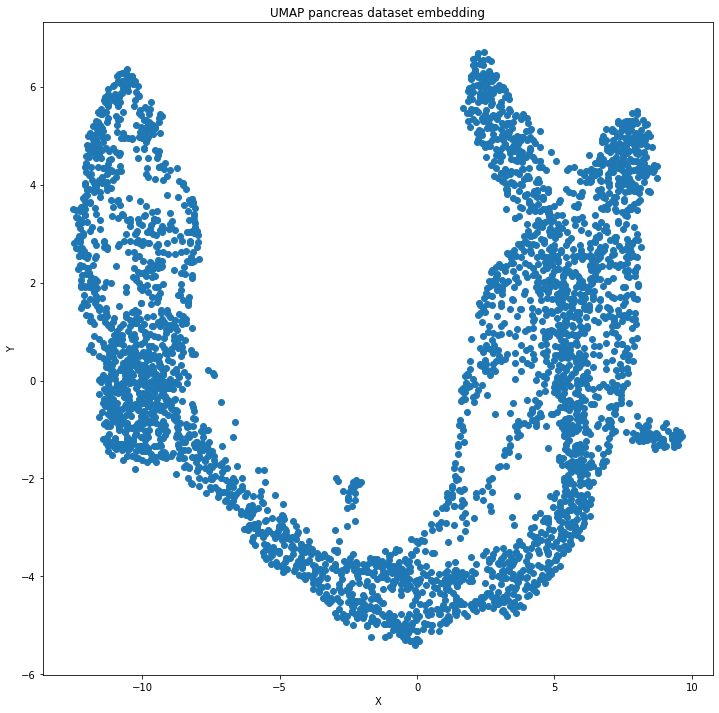

In [28]:
#plot
plt.figure(figsize=(12, 12))
plt.title("UMAP pancreas dataset embedding")
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(umap_p[:, 0],
    umap_p[:, 1])

plt.show()

In [29]:
scv.pp.filter_and_normalize(data)
scv.pp.moments(data)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [30]:
scv.pp.filter_and_normalize(data)
scv.pp.moments(data)

computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [31]:
scv.tl.velocity(data, mode='stochastic')

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [32]:
velocity_p = data.layers['velocity']

 # Embedding of the vector field using scvelo

In [33]:
scv.tl.velocity_graph(data)

computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


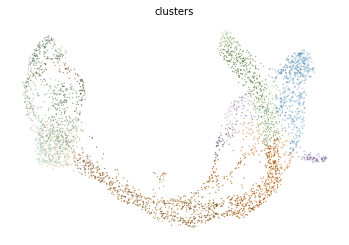

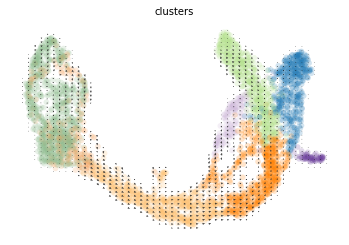

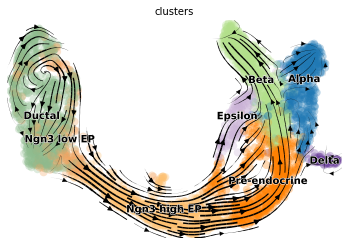

In [34]:
scv.pl.velocity_embedding(data, basis='umap')
scv.pl.velocity_embedding_grid(data, basis='umap')
scv.pl.velocity_embedding_stream(data, basis='umap')

In [35]:
#embedding_param = embedder.fit_transform(data_p)
#data_P = [data_p[:,0],data_p[:,1],data_p[:,2]]
#print(data_p)

In [ ]:
embedding = umap_mapping(data_p)

In [36]:
embedder, embedding_param = PUMAP_mapping(data_p)

AttributeError: nbytes not found